# 处理单张图片的推理测试  
会有引用包的问题，正常如果要单独运行需要将脚本挪到segment-anything这个包的相同路径下

In [1]:
import numpy as np
import cv2
import torch
import torchvision
import matplotlib.pyplot as plt

从ground_truth直接生成BBox的区域，用于模型输入的prompt
同时实现可视化

In [2]:
def get_bbox(gt):
    """
    Given a ground truth segmentation image, returns a bounding box that completely encloses the segmentation.
    :param img: A ground truth segmentation image
    :return: A numpy array of the form [x1, y1, x2, y2] representing the bounding box
    """
    # Convert the image to binary
    _, binary = cv2.threshold(gt, 0, 255, cv2.THRESH_BINARY)
    
    # Find the contours of the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the bounding box of the contours
    x, y, w, h = cv2.boundingRect(contours[0])
    
    # Return the bounding box as a numpy array
    return np.array([x, y, x+w, y+h])

# 使用ipynb可视化操作
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)



In [3]:
# testing code for single-pic bbox generation 
gt_path = '/root/segment-anything/SAM-COD/test_img/GT/example.png'
gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
bbox = get_bbox(gt)


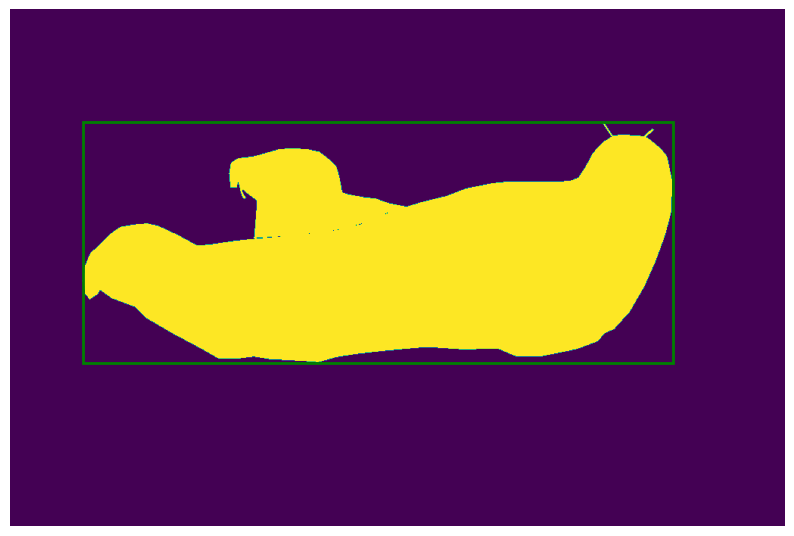

In [4]:

plt.figure(figsize=(10, 10))
plt.imshow(gt)
show_box(bbox, plt.gca())
plt.axis('off')
plt.show()


# 单张图片的推理  
最好在cuda上面跑默认模型（vit_h）

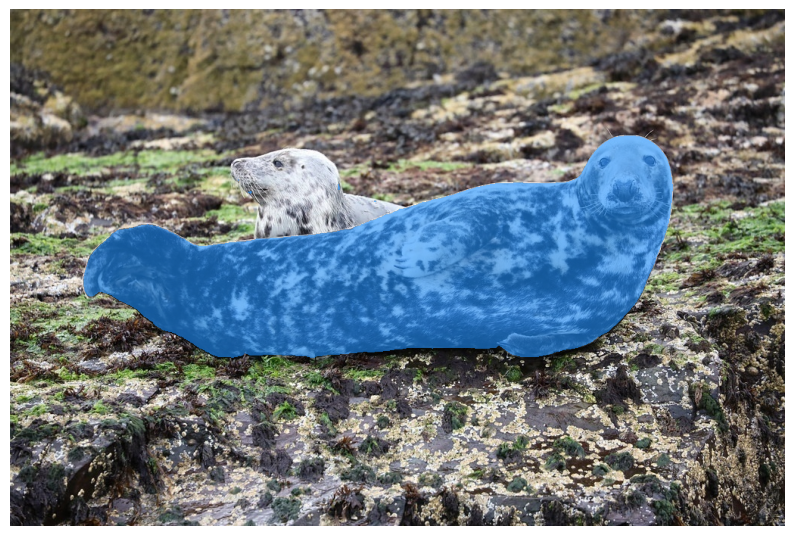

In [5]:
from segment_anything import sam_model_registry, build_sam, SamPredictor 
sam_checkpoint = "/root/autodl-tmp/segment-anything-pth/sam_vit_h_4b8939.pth"
model_type = "vit_h"
# 单卡推理
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

img_path = '/root/segment-anything/SAM-COD/test_img/Imgs/example.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

predictor.set_image(img)    # embedding image using SAM
masks, _, _ = predictor.predict(point_coords= None,     # 推理，生成Masks
                                point_labels= None,
                                box = bbox[None, :],
                                multimask_output=False)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')
show_mask(mask=masks, ax =plt.gca())
plt.show()  
